In [10]:
from scipy.spatial import distance as dst
from mpl_toolkits.basemap import Basemap
from collections import defaultdict
import matplotlib.pyplot as plt
import shapely.geometry as sp
import datetime as dt
import pandas as pd
import pickle as pk
import numpy as np
import itertools
import math
import time
import json
import copy

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following two cells demonstrates the two main csv files we will be working with in the notebook. The cleaned versions of FlightTracks.csv(cleanTracks.csv) and Flight_History.csv(cleanFlights.csv)</p></font><br>
<font size="3">
<b>Input</b> &rarr; cleanTracks.csv, cleanFlightHistory.csv <br>
</div>

In [3]:
cleanTracks=pd.read_csv("Outputs/cleanTracks.csv")
cleanTracks

,received,ground_speed,latitude_degrees,longitude_degrees,flighthistory_id
0,2013-08-14 08:30:56,172,36.207200,-79.425000,306095730
1,2013-08-14 08:31:56,187,36.259400,-79.430000,306095730
2,2013-08-14 08:32:53,214,36.326700,-79.418100,306095730
3,2013-08-14 08:33:53,191,36.363100,-79.383600,306095730
4,2013-08-14 08:34:59,186,36.402200,-79.336400,306095730
...,...,...,...,...,...
81406058,2013-09-11 13:57:30,316,42.680000,-106.449997,308962199
81406059,2013-09-11 13:58:31,279,42.700001,-106.529999,308962199
81406060,2013-09-11 13:59:32,250,42.720001,-106.620003,308962199
81406061,2013-09-11 14:24:46,130,37.630001,-122.099998,308960729


In [4]:
cleanFlights=pd.read_csv("Outputs/cleanFlightHistory.csv")
cleanFlights

,id,departure_airport_icao_code,arrival_airport_icao_code,scheduled_runway_departure,actual_runway_departure,scheduled_runway_arrival,actual_runway_arrival
0,305966493,KSDF,KDEC,2013-08-14 08:40:00,2013-08-14 09:14:00,2013-08-14 09:44:00,2013-08-14 10:12:00
1,306196254,KSDF,KBHM,2013-08-14 09:00:00,2013-08-14 09:04:00,2013-08-14 09:47:00,2013-08-14 09:51:00
2,306196711,KMEM,KCOS,2013-08-14 09:00:00,2013-08-14 09:14:00,2013-08-14 11:01:00,2013-08-14 11:18:00
3,306196678,KMEM,KMIA,2013-08-14 09:00:00,2013-08-14 09:09:00,2013-08-14 10:52:00,2013-08-14 10:58:00
4,306196521,KSDF,KMKE,2013-08-14 09:00:00,2013-08-14 09:15:00,2013-08-14 09:54:00,2013-08-14 10:04:00
...,...,...,...,...,...,...,...
646704,308962754,KMEM,KSAN,2013-09-11 08:58:00,2013-09-11 09:04:00,2013-09-11 12:07:00,2013-09-11 12:09:00
646705,308961528,KSDF,KSGF,2013-09-11 08:59:00,2013-09-11 09:08:00,2013-09-11 10:03:00,2013-09-11 10:03:00
646706,308962550,KMEM,KRIC,2013-09-11 08:59:00,2013-09-11 09:11:00,2013-09-11 10:37:00,2013-09-11 10:46:00
646707,308962750,KSDF,KHSV,2013-09-11 08:59:00,2013-09-11 09:16:00,2013-09-11 09:58:00,2013-09-11 10:26:00


<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell reads the cleanTracks.csv which has a mapping between every flight and its corresponding ground speed in knots captured at 1 minute intervals(timestamps) and outputs the dictionary as a pickle file that maps each flightID to its median ground speed/cruise speed. </p></font><br>
<font size="3">
<b>Input</b> &rarr; cleanTracks.csv <br>
<b>Output</b> &rarr; SpeedDict.pkl </font>
</div>

In [3]:
cleanTracks=pd.read_csv("Outputs/cleanTracks.csv")
cleanTracks.sort_values(by=['received'],inplace=True)
speeds = cleanTracks.groupby(["flighthistory_id"])["ground_speed"].median()
df_dict = speeds.to_dict()
avg_speed = np.array(list(df_dict.values())).mean()
med_speed = np.median(list(df_dict.values()))
print("The Average Cruise Speed of a flight is ",avg_speed)
print("The Median Cruise Speed of a flight is ",med_speed)
print("The Number of flights whose cruise speed is known",len(df_dict))
speedDictFile=open("Outputs/SpeedDict.pkl","wb")
pk.dump(df_dict,speedDictFile)
speedDictFile.close()

The Average Cruise Speed of a flight is  386.2909277154822
The Median Cruise Speed of a flight is  407.5
The Number of flights whose cruise speed is known 631131


<h1>Test Days</h1><br>
<font size="4",style="font-family:Ubuntu"> <p> The days tested for are given below - we obtain the 3 metrics for each of the test days and compare the metric with the predicted value from the GA <br><br> Range = [2013-08-14,2013-09-11]</p></font><br>

In [5]:
TEST_DAYS=["2013-08-16"]
NumFlights=5000

<p><font size="4",style="font-family:Ubuntu"> <p> The cell below creates seperate .csv files for the tracks and flights of each test day in order to reduce the IO burden, as we would not want to read the entire csv files(cleanFlightHistory and cleanTracks) for the whole month since we just want to analyze a single test day </p>
<b>Input</b> &rarr; cleanTracks.csv,cleanFlightHistory.csv <br>
<b>Output</b> &rarr; 2N csv files where N is the number of test days, for each test day we generate 2 csv files, one containing all the flights scheduled to depart that day({date}_flights.csv) and all the flight tracks recorded that day ({date}_tracks.csv) </font></font><br>

In [3]:
cleanTracks=pd.read_csv("Outputs/cleanTracks.csv")
cleanFlights=pd.read_csv("Outputs/cleanFlightHistory.csv")
for date in TEST_DAYS:
    tracktemp=cleanTracks[cleanTracks['received'].str.contains(date)].copy()
    flighttemp=cleanFlights[cleanFlights['scheduled_runway_departure'].str.contains(date)].copy()
    tracktemp.to_csv(f"MetricFiles/DayWiseInput/{date}_tracks.csv",index=False)
    flighttemp.to_csv(f"MetricFiles/DayWiseInput/{date}_flights.csv",index=False)

<h1>Metric 1 - Traffic Factor</h1>

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell block reads the {test_day}_tracks.csv which has a mapping between every flight and the coordinates of its actual path measured at constant time intervals. We use this data to obtain the TrafficFactor for each test day.<b> The Traffic Factor is a measure of the maximum number of aircraft present in every sector (measure the sector count of each sector) at any given time across the entire day.</b> </p></font><br>
<font size="3">
<b>Input</b> &rarr; {test_day}_tracks.csv <br>
<b>Output</b> &rarr; N pickle files where N is the number of days to be tested. &rarr; Each one a dict mapping each Sector to its traffic factor </font>
</div>

In [11]:
def getChunk(Point,SectorChunkDict):
    innerDict=SectorChunkDict[math.ceil(Point[0]/1000000)*1000000]
    Y=0
    for key in innerDict.keys():
        if key >= Point[1]:
            Y=key
            break
    return innerDict[Y] if Y!=0 else []
def findSectorPath(path,sectorPath,z,SectorChunkDict,output):
    sector=-1
    for pointIdx in range(len(path)):
        sectorList=getChunk(path[pointIdx],SectorChunkDict)
        for i in sectorList:
            if len(output[i]) < 3:
                continue
            if sp.Polygon(output[i]).contains(sp.Point(path[pointIdx])):
                sector=i
                break
        if sector!=-1:
            sectorPath.append(sector)
        else:
            z.append(pointIdx)

In [12]:
ConvexHulls = pk.load(open("Outputs/ConvexDict.pkl", "rb"))
m = pk.load(open("Outputs/M_ConversionMetric.pkl", "rb"))
SectorChunkDict=pk.load(open("Outputs/SectorChunkDict.pkl", "rb"))
AirportSectorDict=pk.load(open("Outputs/airportSectorDict.pkl", "rb"))
NumSectors=1250
TimeUnits=2880
for date in TEST_DAYS:
    SectorTimeDict=[[0 for colnum in range(TimeUnits)] for rownum in range(NumSectors)]
    dayTracks=pd.read_csv(f"MetricFiles/DayWiseInput/{date}_tracks.csv")
    dayFlights=pd.read_csv(f"MetricFiles/DayWiseInput/{date}_flights.csv")[:NumFlights]
    dayTracks.sort_values(by=['flighthistory_id','received'],inplace=True)
    dayTracks.reset_index(drop=True, inplace=True)
    east,north=m(dayTracks["longitude_degrees"],dayTracks["latitude_degrees"])
    dayTracks["easting"]=east
    dayTracks["northing"]=north
    InvalidID=[]
    flightIDs=list(dayFlights["id"])
    for ID in flightIDs:
        sectorPath=[]
        z=[]
        tracks=dayTracks[dayTracks["flighthistory_id"]==ID].copy()
        tracks.reset_index(drop=True, inplace=True)
        if(len(tracks)==0):
            InvalidID.append(ID)
        else:
            path=list(zip(tracks["easting"],tracks["northing"]))
            sectorPath=[]
            z=[]
            findSectorPath(path,sectorPath,z,SectorChunkDict,ConvexHulls)
            tracks.drop(z, axis=0, inplace=True)
            timings=list(map(lambda x:dt.datetime.fromisoformat(str(x)),tracks["received"]))
            rowIdx=0
            NumRows=len(sectorPath)
            Flight=dayFlights[dayFlights["id"]==ID]
            startSec=AirportSectorDict[Flight["departure_airport_icao_code"].values[0]]
            endSec=AirportSectorDict[Flight["arrival_airport_icao_code"].values[0]]
            realSecPath=[]
            startTime=dt.datetime.fromisoformat(str(Flight["actual_runway_departure"].values[0]))
            endTime=dt.datetime.fromisoformat(str(Flight["actual_runway_arrival"].values[0]))
            realRowArr=[(startTime.hour*60)+(startTime.minute)]
            realSecArr=[startSec]
            seenSec=startSec
            row=0
            for sec in sectorPath:
                if(sec!=seenSec):
                    realRowArr.append((timings[row].hour*60)+timings[row].minute)
                    realSecArr.append(sec)
                    seenSec=sec
                if(sec==endSec):
                    break
                row+=1
            realRowArr.append((endTime.hour*60)+endTime.minute)
            for i in range(len(realSecArr)):
                for j in range(realRowArr[i],realRowArr[i+1]):
                    SectorTimeDict[realSecArr[i]][j]+=1
    kFile=open("MetricFiles/CustomSectorTimeDict.pkl","wb")
    pk.dump(SectorTimeDict,kFile)
    kFile.close()
    K=[]
    for i in range(NumSectors):
        K.append(max(SectorTimeDict[i]))
    kFile=open("MetricFiles/CustomKDict.pkl","wb")
    pk.dump(K,kFile)
    kFile.close()

<h1>Metric 2 - Aerial Time</h1>
<h1>Metric 3 - Ground Delay</h1>

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell block reads the {test_day}_flights.csv which details every single flight that was scheduled to depart on {test_day} We use this dataset to obtain the <b>actual aerial time </b> based on the difference between actual runway arrival and actual runway departure and the <b> ground holding delay time </b> based on the difference between actual runway departure and scheduled runway departure</p></font><br>
<font size="3">
<b>Input</b> &rarr; {test_day}_flights.csv <br>
<b>Output</b> &rarr; N csv files &rarr; each contains 2 columns, aerial time and ground delay </font>
</div>

In [7]:
for day in TEST_DAYS:
    dayDf=pd.read_csv(f"MetricFiles/DayWiseInput/{day}_flights.csv")[:NumFlights]
    display(dayDf)
    dayDf.sort_values(by=["scheduled_runway_departure"], inplace = True)
    ground_delay = []
    actual_air_time = []
    srd=list(map(lambda x:dt.datetime.fromisoformat(str(x)),dayDf["scheduled_runway_departure"]))
    ard=list(map(lambda x:dt.datetime.fromisoformat(str(x)),dayDf["actual_runway_departure"]))
    ara=list(map(lambda x:dt.datetime.fromisoformat(str(x)),dayDf["actual_runway_arrival"]))
    NumRows=len(ard)
    for i in range(NumRows):
        ground_delay.append((ard[i] - srd[i])/pd.Timedelta(minutes=1))
        actual_air_time.append((ara[i]-ard[i])/pd.Timedelta(minutes=1))
    dayno_data = pd.DataFrame()
    dayno_data.insert(0, "Aerial Time", actual_air_time)
    dayno_data.insert(1, "ground_delay", ground_delay)
    dayno_data.to_csv(f"MetricFiles/{day}-gd-aat.csv",index=False)

,id,departure_airport_icao_code,arrival_airport_icao_code,scheduled_runway_departure,actual_runway_departure,scheduled_runway_arrival,actual_runway_arrival
0,306043857,KLGA,KSTL,2013-08-16 00:00:00,2013-08-16 00:07:00,2013-08-16 02:08:00,2013-08-16 02:04:00
1,306011989,KCMH,KCLT,2013-08-16 00:00:00,2013-08-16 00:06:00,2013-08-16 01:03:00,2013-08-16 01:03:00
2,306048464,KMCO,KLAS,2013-08-16 00:00:00,2013-08-16 00:04:00,2013-08-16 04:21:00,2013-08-16 04:28:00
3,306058850,KORD,KSFO,2013-08-16 00:00:00,2013-08-16 00:00:00,2013-08-16 04:00:00,2013-08-16 04:04:00
4,306054413,KMYR,KCLT,2013-08-16 00:00:00,2013-08-15 23:47:00,2013-08-16 00:34:00,2013-08-16 00:15:00
...,...,...,...,...,...,...,...
4995,306389763,KMEM,KOKC,2013-08-16 09:17:00,2013-08-16 09:48:00,2013-08-16 10:28:00,2013-08-16 10:50:00
4996,306389430,KCVG,KHRL,2013-08-16 09:17:00,2013-08-16 10:30:00,2013-08-16 12:00:00,2013-08-16 12:55:00
4997,306389426,KCVG,KIAH,2013-08-16 09:18:00,2013-08-16 10:41:00,2013-08-16 11:19:00,2013-08-16 12:35:00
4998,306389431,KCVG,KGSO,2013-08-16 09:18:00,2013-08-16 10:51:00,2013-08-16 10:17:00,2013-08-16 11:40:00


<h1>Input File Generation</h1>

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell generates the test files which will serve as an input to the GA via the website</p></font><br>
<font size="3">
<b>Input</b> &rarr; {test_day}_flights.csv <br>
<b>Output</b> &rarr; N txt files &rarr; each serves as a single days' worth of flights to be input to the model  </font>
</div>

In [8]:
AirportDB=json.load(open('Outputs/airports.json', encoding = "utf-8"))
speedDict=pk.load(open("Outputs/SpeedDict.pkl",'rb'))
for day in TEST_DAYS:
    dayDf=pd.read_csv(f"MetricFiles/DayWiseInput/{day}_flights.csv")[:NumFlights]
    dayDf.sort_values(by=["scheduled_runway_departure"], inplace = True)
    ids=list(dayDf['id'])
    source=list(dayDf["departure_airport_icao_code"])
    destination=list(dayDf["arrival_airport_icao_code"])
    startTime=[dt.datetime.fromisoformat(str(date)) for date in dayDf["scheduled_runway_departure"]]
    triplets=list(zip(ids,source,destination))
    start=[]
    for s in startTime:
        hour=s.hour
        minute=s.minute
        if minute < 10:
            minute="0" + str(minute)
        start.append(str(hour) + ":" + str(minute))
    toPrint=""
    for i in range(len(triplets)):
        flightID,sourceAirport,destinationAirport=triplets[i]
        sourceAirportName=AirportDB[sourceAirport]["name"]
        destinationAirportName=AirportDB[destinationAirport]["name"]
        if flightID not in speedDict:
            speedDict[flightID]=407.5
        toPrint+=f"{sourceAirportName},{destinationAirportName},1,{start[i]},{speedDict[flightID]}"
        if i!=len(triplets)-1:
            toPrint+="\n"
    f = open(f"MetricFiles/Input Text Files/{day}-pairs.txt", "w")
    f.write(toPrint)
    f.close()

<h1>Comparison Graphs</h1>

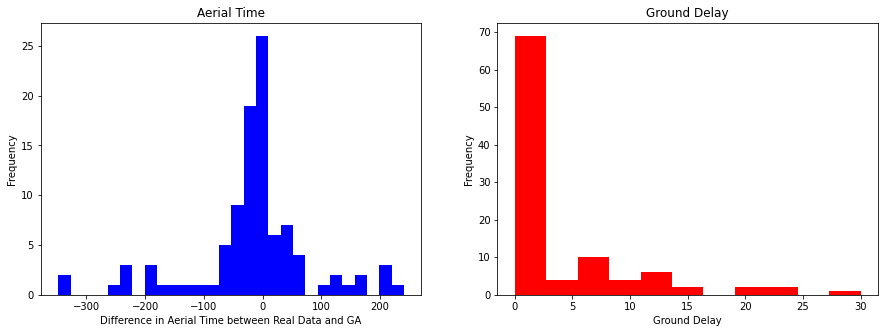

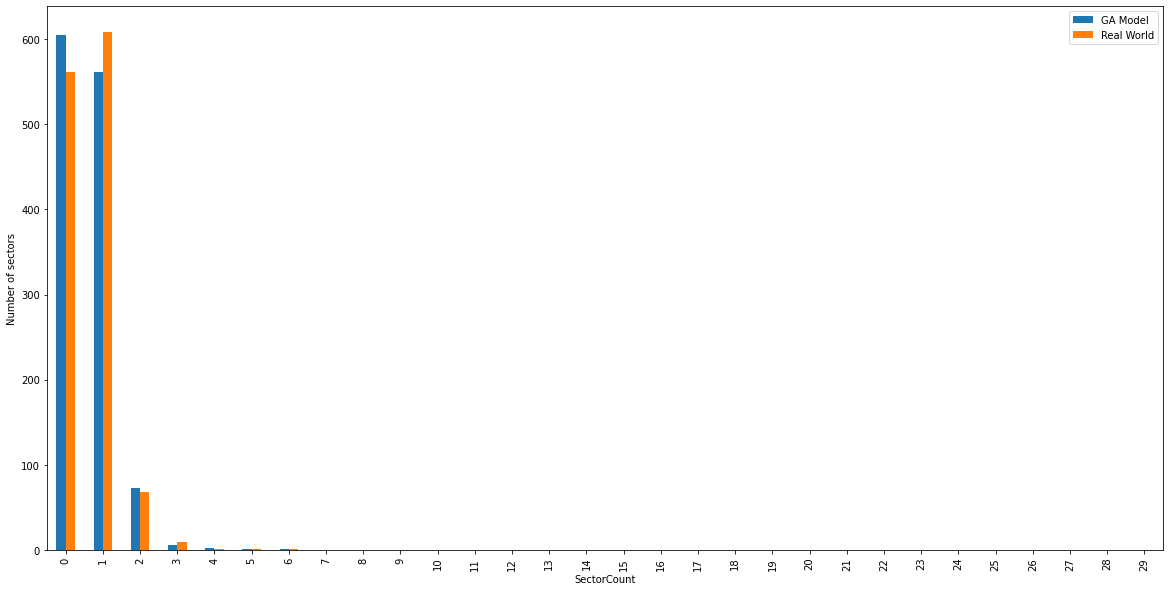

The RMSD error for Aerial Time is  101.1526074799854
 Average Ground Delay is  3.65


In [9]:
TrafficFactorGA=open("../website/backend/OutputFolder/TrafficFactor.txt")
MetricsGA=pd.read_csv("../website/backend/OutputFolder/AerialTimeGD.txt")

TrafficFactorReal = pk.load(open("MetricFiles/CustomKDict.pkl", "rb"))
SecTimeDictReal=pk.load(open("MetricFiles/CustomSectorTimeDict.pkl", "rb"))
RealMetrics=pd.read_csv("MetricFiles/2013-08-16-gd-aat.csv")
fig, ax = plt.subplots(1,2,figsize=(15,5))
realAT=RealMetrics["Aerial Time"]
GA_AT=MetricsGA["Aerial Time"]
realGD=RealMetrics["ground_delay"]
GA_GD=MetricsGA["Ground Holding"]
absDiffAT=[]
absDiffGD=[]
GATrafFactor=defaultdict(int)
RealTrafFactor=defaultdict(int)
for line in TrafficFactorGA:
    GATrafFactor[int(float(line))]+=1
for value in TrafficFactorReal:
    RealTrafFactor[value]+=1
data={"SectorCount":[i for i in range(30)],
     "GA Model":[GATrafFactor[sector] for sector in range(30)],
     "Real World":[RealTrafFactor[sector] for sector in range(30)]}
SectorDataFrame=pd.DataFrame(data)
for i in range(len(GA_AT)):
    absDiffAT.append(realAT[i]-GA_AT[i])
    absDiffGD.append(GA_GD[i])
q25, q75 = np.percentile(absDiffAT, [25, 75])
bin_width = 2 * (q75 - q25) * len(absDiffAT) ** (-1/3)
binsAT = round((max(absDiffAT) - min(absDiffAT)) / bin_width)

q25, q75 = np.percentile(absDiffGD, [25, 75])
bin_width = 2 * (q75 - q25) * len(absDiffGD) ** (-1/3)
binsGD = round((max(absDiffGD) - min(absDiffGD)) / bin_width)

ax[0].hist(absDiffAT, range=(min(absDiffAT),max(absDiffAT)),color='b', bins=binsAT)
ax[1].hist(absDiffGD, range=(min(absDiffGD),max(absDiffGD)),color='r', bins=binsGD)
ax[0].title.set_text('Aerial Time')
ax[1].title.set_text('Ground Delay')
ax[0].set_xlabel('Difference in Aerial Time between Real Data and GA')
ax[1].set_xlabel('Ground Delay')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
SectorDataFrame.plot.bar(x='SectorCount',figsize=(20,10),ylabel = 'Number of sectors')
plt.show()
RMSE_AT=0
RMSE_GD=0
for i in range(len(GA_AT)):
    RMSE_AT+=((realAT[i]-GA_AT[i])**2)
    RMSE_GD+=((realGD[i]-GA_GD[i])**2)
RMSE_AT/=len(GA_AT)
RMSE_GD/=len(GA_AT)
RMSE_AT=RMSE_AT**(0.5)
RMSE_GD=RMSE_GD**(0.5)
print("The RMSD error for Aerial Time is ",RMSE_AT)
print(" Average Ground Delay is ",sum(GA_GD)/len(GA_GD))